# CLUSTERING SEGMENTASI PELANGGAN

Nama: Indah Yunita

NIM: 190411100067

# Instalasi Library

In [1]:
#Library untuk dataframe dan visualisasi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [2]:
!pip install scikit-learn-extra

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 36.1 MB/s 


In [3]:
#library untuk clustering
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer


# Inisialiasasi Data dan Membuat Dataframe

Sumber data: https://www.kaggle.com/datasets/mashlyn/online-retail-ii-uci

Parameter:

Invoice: Merupakan nomor transaksi berukuran 6 digit. Masing-masing nomor 
bersifat unik untuk setiap transaksi. Jika kode transaksi ini diawali dengan huruf ’C’ maka menandakan bahwa transaksi tersebut dibatalkan (Cancelled)

StockCode: Merupakan kode produk sebanyak 5 digit yang masing-masing kode mewakili setiap produk yang dijual

Description: Merupakan nama produk yang dijual 

InvoiceDate: Merupakan tanggal dan waktu transaksi

Price: Merupakan harga produk per unit dalam satuan mata uang sterling

Customer ID: Merupakan kode pelanggan berukuran 5 digit yang unik untuk masing-masing pelanggan

Country: Merupakan nama kota tempat pelanggan


In [4]:
url = "https://raw.githubusercontent.com/inyunita/Dataset-KP/main/online_retail_II.csv"
df_retail = pd.read_csv(url, on_bad_lines='skip')
df_retail.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


# Info Dataset

In [5]:
df_retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


Jumlah Baris dan Kolom

In [6]:
df_retail.shape

(1067371, 8)

Deskripsi Dataset

In [7]:
df_retail.describe()

,Quantity,Price,Customer ID
count,1.067371e+06,1.067371e+06,824364.000000
mean,9.938898e+00,4.649388e+00,15324.638504
std,1.727058e+02,1.235531e+02,1697.464450
min,-8.099500e+04,-5.359436e+04,12346.000000
25%,1.000000e+00,1.250000e+00,13975.000000
50%,3.000000e+00,2.100000e+00,15255.000000
75%,1.000000e+01,4.150000e+00,16797.000000
max,8.099500e+04,3.897000e+04,18287.000000


#  Cleaning Data

Jumlah Data yang Kosong

In [8]:
df_retail.isna().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

In [9]:
df_null = round(100*(df_retail.isnull().sum())/len(df_retail), 2)
df_null

Invoice         0.00
StockCode       0.00
Description     0.41
Quantity        0.00
InvoiceDate     0.00
Price           0.00
Customer ID    22.77
Country         0.00
dtype: float64

Jumlah Data Setelah Penghapusan Data yang Kosong

In [10]:
df_retail = df_retail.dropna()
df_retail.shape

(824364, 8)

In [11]:
df_retail.isna().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

Merubah Tipe data Customer ID ke string

In [12]:
#merubah tipe data customer ID ke string
df_retail['Customer ID'] = df_retail['Customer ID'].astype(str)

In [13]:
df_retail.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 824364 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      824364 non-null  object 
 1   StockCode    824364 non-null  object 
 2   Description  824364 non-null  object 
 3   Quantity     824364 non-null  int64  
 4   InvoiceDate  824364 non-null  object 
 5   Price        824364 non-null  float64
 6   Customer ID  824364 non-null  object 
 7   Country      824364 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 56.6+ MB


# Persiapan Data

Analisis customer didasarkan pada 3 faktor:
1. R (Recency): Jumlah hari sejak terakhir transaksi (Seberapa baru pelanggan melakukan transaksi)
2. F (Frequency): Jumlah Transaksi
3. M (Monetary): Total jumlah nominal transaksi

Menghilangkan transaksi yang dibatalkan dan transaksi yang bernilai negatif

In [14]:
#menghilangkan transaksi yang dibatalkan
df_retail = df_retail[~df_retail["Invoice"].str.contains("C", na = False)]
df_retail = df_retail[(df_retail["Quantity"]>0)]
df_retail = df_retail[(df_retail["Price"]>0)]


In [15]:
df_retail.shape

(805549, 8)

Menghitung dan Menggabungkan amount sesuai dengan customer ID

In [16]:
#Atribut Baru : Monetary
df_retail['Amount'] = df_retail['Quantity']*df_retail['Price']
rfm_monetary = df_retail.groupby('Customer ID')['Amount'].sum()
rfm_monetary = rfm_monetary.reset_index()
rfm_monetary.head()

,Customer ID,Amount
0,12346.0,77556.46
1,12347.0,5633.32
2,12348.0,2019.40
3,12349.0,4428.69
4,12350.0,334.40


Jumlah setelah digrup per Customer ID

In [17]:
rfm_monetary.shape

(5878, 2)

Jumlah Cust ID

In [18]:
unik = df_retail['Customer ID'].unique()
unik.shape


(5878,)

Invoice masing-masing cust ID

In [19]:
pd.DataFrame(df_retail.groupby('Customer ID')['Invoice'])


,0,1
0,12346.0,27994 491725 28251 491742 28254 49...
1,12347.0,423892 529924 423893 529924 423894 ...
2,12348.0,358167 524140 358168 524140 358169 52...
3,12349.0,179304 506394 179305 506394 179306 ...
4,12350.0,605784 543037 605785 543037 605786 54...
...,...,...
5873,18283.0,97175 498547 97176 498547 97177 ...
5874,18284.0,370322 525114 370323 525114 370324 52...
5875,18285.0,93653 498149 93654 498149 93655 49814...
5876,18286.0,34314 492250 34315 492250 34316 49...


Menghitung dan Mengelompokkan Frequency per ID

In [20]:
#Atribut baru: Frequency
rfm_frequency = df_retail.groupby('Customer ID')['Invoice'].nunique()
rfm_frequency = rfm_frequency.reset_index()
rfm_frequency.columns = ['Customer ID', 'Frequency']
rfm_frequency.head()

,Customer ID,Frequency
0,12346.0,12
1,12347.0,8
2,12348.0,5
3,12349.0,4
4,12350.0,1


Menggabungkan Dataframe monetary dan frequency

In [21]:
#merging 2 dataframe
rfm = pd.merge(rfm_monetary, rfm_frequency, on= "Customer ID", how='inner')
rfm.head()

,Customer ID,Amount,Frequency
0,12346.0,77556.46,12
1,12347.0,5633.32,8
2,12348.0,2019.40,5
3,12349.0,4428.69,4
4,12350.0,334.40,1


Recency

In [22]:
#Atribut Baru: Recency
#Convert datetime dalam format yg benar

df_retail["InvoiceDate"] = pd.to_datetime(df_retail["InvoiceDate"])

Transaksi terakhir di retail

In [23]:
max_date = max(df_retail["InvoiceDate"])
max_date

Timestamp('2011-12-09 12:50:00')

Selisih masing-masing transaksi dengan transaksi terakhir

In [24]:
#Selisih max date dan transaction date
df_retail['Diff'] = max_date - df_retail['InvoiceDate']
df_retail.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Amount,Diff
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4,738 days 05:05:00
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,738 days 05:05:00
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,738 days 05:05:00
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8,738 days 05:05:00
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0,738 days 05:05:00


In [25]:
df_retail.tail()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Amount,Diff
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60,0 days
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,0 days
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,0 days
1067369,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France,14.85,0 days
1067370,581587,POST,POSTAGE,1,2011-12-09 12:50:00,18.00,12680.0,France,18.00,0 days


Selisih masing-masing transaksi digrupby dengan customer ID (dicari yang minimal/yang paling dekat dengan transaksi terakhir)

In [26]:
rfm_recency = df_retail.groupby('Customer ID')['Diff'].min()
rfm_recency = rfm_recency.reset_index()
rfm_recency.head()

,Customer ID,Diff
0,12346.0,325 days 02:49:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [27]:
#tampilkan jumlah harinya saja
rfm_recency['Diff'] = rfm_recency['Diff'].dt.days
rfm_recency.head()

,Customer ID,Diff
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [28]:
#merge rfm
rfm = pd.merge(rfm, rfm_recency, on="Customer ID", how='inner')
rfm.columns = ['Customer ID', 'Amount', 'Frequency', 'Recency']
rfm.head()

,Customer ID,Amount,Frequency,Recency
0,12346.0,77556.46,12,325
1,12347.0,5633.32,8,1
2,12348.0,2019.40,5,74
3,12349.0,4428.69,4,18
4,12350.0,334.40,1,309


In [29]:
rfm

,Customer ID,Amount,Frequency,Recency
0,12346.0,77556.46,12,325
1,12347.0,5633.32,8,1
2,12348.0,2019.40,5,74
3,12349.0,4428.69,4,18
4,12350.0,334.40,1,309
...,...,...,...,...
5873,18283.0,2736.65,22,3
5874,18284.0,461.68,1,431
5875,18285.0,427.00,1,660
5876,18286.0,1296.43,2,476


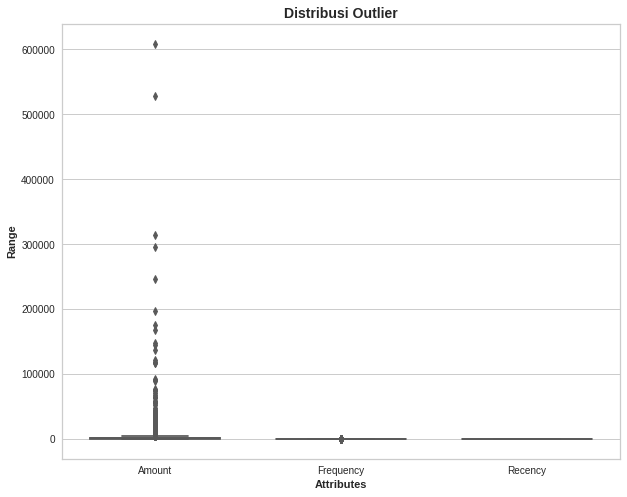

In [30]:
#Analisis outliers dari Amount, Frequency, dan Recency
atribut = ['Amount', 'Frequency', 'Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[atribut], orient="v", palette = "Set2", whis=1.5, saturation=1, width=0.7)

plt.title ("Distribusi Outlier", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')
plt.savefig("Outlier Sebelum dihilangkan")


In [31]:
 #menghilangkan outlier pada atribut amount
 Q1 = rfm.Amount.quantile(0.05)
 Q3 = rfm.Amount.quantile(0.95)
 IQR = Q3 - Q1
 rfm = rfm[(rfm.Amount >= Q1 - 1.5*IQR) & (rfm.Amount <= Q3 + 1.5*IQR )]

 #menghilangkan outlier pada atribut recency
 Q1 = rfm.Recency.quantile(0.05)
 Q3 = rfm.Recency.quantile(0.95)
 IQR = Q3 - Q1
 rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR )]

#menghilangkan outlier pada atribut Frequency
 Q1 = rfm.Frequency.quantile(0.05)
 Q3 = rfm.Frequency.quantile(0.95)
 IQR = Q3 - Q1
 rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR )]


In [32]:
rfm

,Customer ID,Amount,Frequency,Recency
1,12347.0,5633.32,8,1
2,12348.0,2019.40,5,74
3,12349.0,4428.69,4,18
4,12350.0,334.40,1,309
5,12351.0,300.93,1,374
...,...,...,...,...
5873,18283.0,2736.65,22,3
5874,18284.0,461.68,1,431
5875,18285.0,427.00,1,660
5876,18286.0,1296.43,2,476


In [33]:
rfm = rfm.reset_index()
rfm=rfm.drop(['index'],axis=1)
rfm

,Customer ID,Amount,Frequency,Recency
0,12347.0,5633.32,8,1
1,12348.0,2019.40,5,74
2,12349.0,4428.69,4,18
3,12350.0,334.40,1,309
4,12351.0,300.93,1,374
...,...,...,...,...
5769,18283.0,2736.65,22,3
5770,18284.0,461.68,1,431
5771,18285.0,427.00,1,660
5772,18286.0,1296.43,2,476


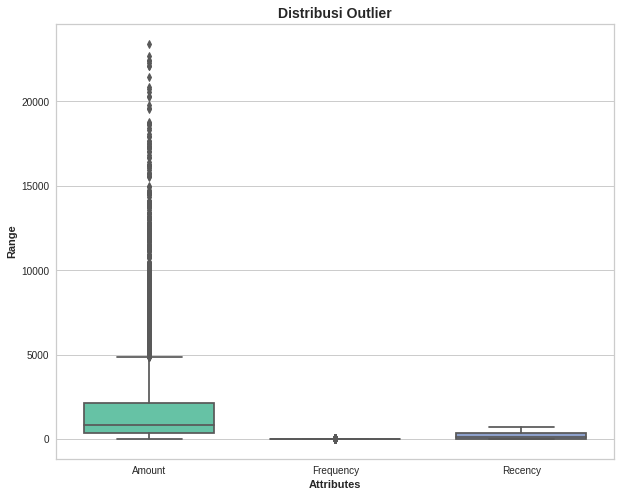

In [34]:
 #Analisis outliers dari Amount, Frequency, dan Recency (Setelah dihilangkan outliernya)
atribut = ['Amount', 'Frequency', 'Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[atribut], orient="v", palette = "Set2", whis=1.5, saturation=1, width=0.7)

plt.title ("Distribusi Outlier", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')
plt.savefig("Outlier Setelah dihilangkan")

Rescalling Atribute (Normalisasi)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


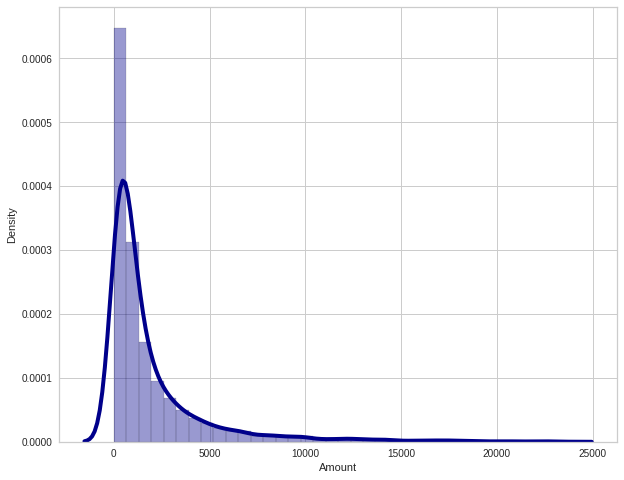

In [35]:
#melihat distribusi data
import seaborn as sns
sns.distplot(rfm['Amount'], hist=True, kde=True,
             bins = int(180/5), color='darkblue',
             hist_kws = {'edgecolor':'black'},
             kde_kws={'linewidth':4})


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


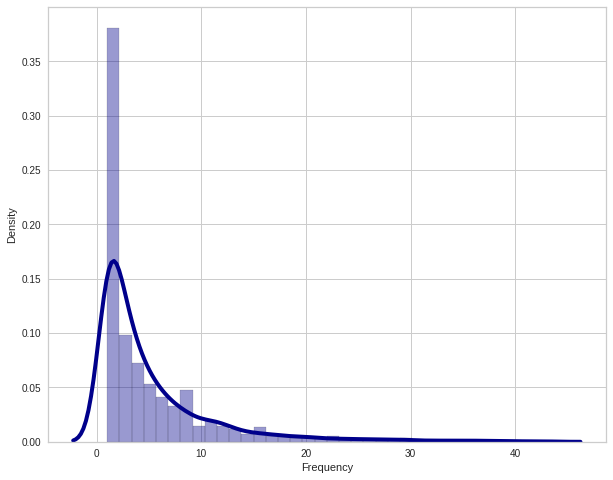

In [36]:
sns.distplot(rfm['Frequency'], hist=True, kde=True,
             bins = int(180/5), color='darkblue',
             hist_kws = {'edgecolor':'black'},
             kde_kws={'linewidth':4})

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


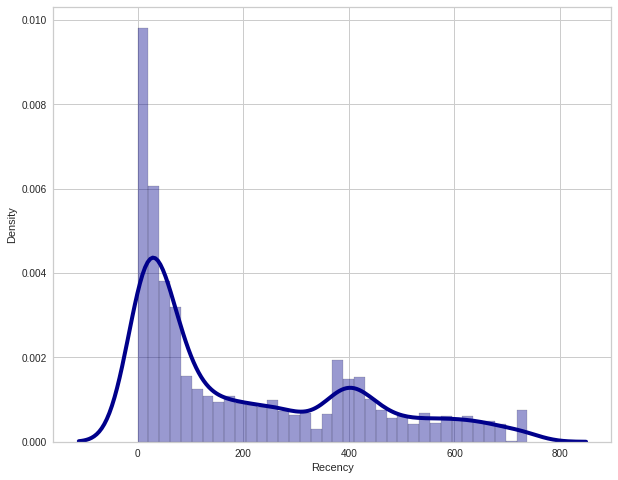

In [37]:
sns.distplot(rfm['Recency'], hist=True, kde=True,
             bins = int(180/5), color='darkblue',
             hist_kws = {'edgecolor':'black'},
             kde_kws={'linewidth':4})

In [38]:
#karena data tidak berdistribusi normal, maka untuk normalisasi data menggunakan minmax scaller
rfm_attribute = rfm[['Amount', 'Frequency', 'Recency']]
scaler = MinMaxScaler()

#fit transform
rfm_scaled = scaler.fit_transform(rfm_attribute)



In [39]:
rfm_scaled

array([[0.2404462 , 0.16666667, 0.00135501],
       [0.08611295, 0.0952381 , 0.100271  ],
       [0.18900221, 0.07142857, 0.02439024],
       ...,
       [0.01810915, 0.        , 0.89430894],
       [0.05523835, 0.02380952, 0.64498645],
       [0.17850954, 0.14285714, 0.05691057]])

In [40]:
rfm_scaled = pd.DataFrame(rfm_scaled)
rfm_scaled.columns = ['Amount','Frequency','Recency']
rfm_scaled

,Amount,Frequency,Recency
0,0.240446,0.166667,0.001355
1,0.086113,0.095238,0.100271
2,0.189002,0.071429,0.024390
3,0.014155,0.000000,0.418699
4,0.012725,0.000000,0.506775
...,...,...,...
5769,0.116743,0.500000,0.004065
5770,0.019590,0.000000,0.584011
5771,0.018109,0.000000,0.894309
5772,0.055238,0.023810,0.644986


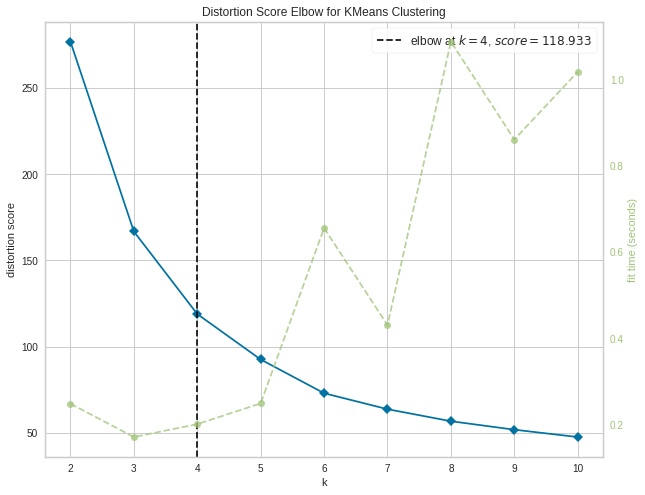

4

In [41]:
kmeans_model = KMeans()
elbow = KElbowVisualizer(kmeans_model, k=(2,11))
elbow.fit(rfm_scaled)
elbow.show()
elbow.elbow_value_

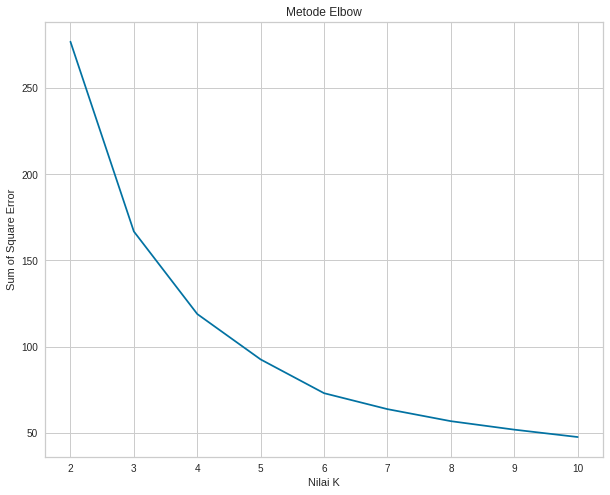

In [42]:
sse = []
K = range(2, 11)
for i in K:
  kmeans = KMeans(n_clusters=i,  max_iter=300, n_init=10, random_state=0)
  kmeans.fit(rfm_scaled)
  sse.append(kmeans.inertia_)

plt.plot(K, sse, 'bx-')
plt.title('Metode Elbow')
plt.xlabel('Nilai K')
plt.ylabel('Sum of Square Error')
plt.savefig('Elbow K means')
plt.show()

In [43]:
nilai_k = []
sil_score=[]
for kluster in range (2,11):
  kmeans = KMeans(n_clusters=kluster)
  nilai_k.append(kluster)
  kmeans.fit(rfm_scaled)
  from sklearn.metrics import silhouette_score
  score = silhouette_score(rfm_scaled, kmeans.labels_)
  sil_score.append(score)

In [44]:
tbl_sil = pd.DataFrame({'Nilai K': nilai_k, 'Silhouette Score' : sil_score})
tbl_sil

,Nilai K,Silhouette Score
0,2,0.568397
1,3,0.569344
2,4,0.526806
3,5,0.470368
4,6,0.477490
5,7,0.454945
6,8,0.452507
7,9,0.428247
8,10,0.416208


In [45]:
nilai_k = []
DBI_score=[]
for kluster in range (2,11):
  kmeans = KMeans(n_clusters=kluster)
  nilai_k.append(kluster)
  kmeans.fit(rfm_scaled)
  from sklearn.metrics import davies_bouldin_score
  score = davies_bouldin_score(rfm_scaled, kmeans.labels_)
  DBI_score.append(score)

In [46]:
tbl_DBI = pd.DataFrame({'Nilai K': nilai_k, 'DBI Score' : DBI_score})
tbl_DBI

,Nilai K,DBI Score
0,2,0.623948
1,3,0.676708
2,4,0.672988
3,5,0.761286
4,6,0.723385
5,7,0.820886
6,8,0.792678
7,9,0.836304
8,10,0.847086


Model K-Means dengan K=4

In [47]:
kmeans_k4 = KMeans(n_clusters=4)
kmeans_k4.fit(rfm_scaled)

KMeans(n_clusters=4)

In [48]:
rfm_scaled

,Amount,Frequency,Recency
0,0.240446,0.166667,0.001355
1,0.086113,0.095238,0.100271
2,0.189002,0.071429,0.024390
3,0.014155,0.000000,0.418699
4,0.012725,0.000000,0.506775
...,...,...,...
5769,0.116743,0.500000,0.004065
5770,0.019590,0.000000,0.584011
5771,0.018109,0.000000,0.894309
5772,0.055238,0.023810,0.644986


In [49]:
rfm_kmeans = rfm.copy()
rfm_kmeans['Cluster'] = kmeans_k4.labels_
rfm_kmeans

,Customer ID,Amount,Frequency,Recency,Cluster
0,12347.0,5633.32,8,1,0
1,12348.0,2019.40,5,74,0
2,12349.0,4428.69,4,18,0
3,12350.0,334.40,1,309,1
4,12351.0,300.93,1,374,1
...,...,...,...,...,...
5769,18283.0,2736.65,22,3,2
5770,18284.0,461.68,1,431,1
5771,18285.0,427.00,1,660,3
5772,18286.0,1296.43,2,476,1


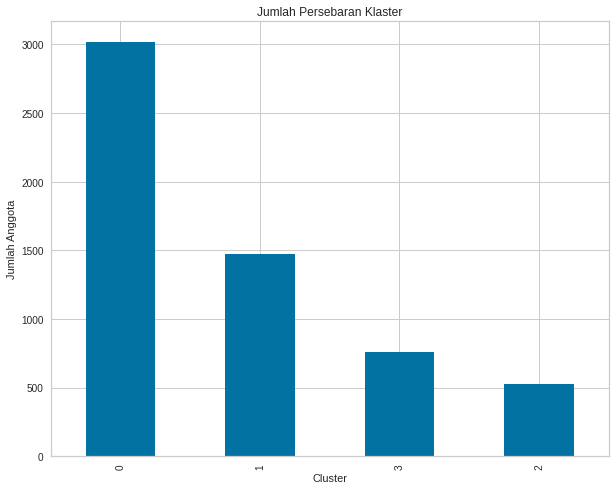

In [50]:
pd.value_counts(rfm_kmeans['Cluster']).plot.bar()
plt.title('Jumlah Persebaran Klaster')
plt.xlabel('Cluster')
plt.ylabel('Jumlah Anggota')
plt.savefig('Jumlah Persebaran Klaster')
rfm_kmeans['Cluster'].value_counts()
plt.show()

In [51]:
anggota_cluster = pd.DataFrame(rfm_kmeans.groupby('Cluster')['Customer ID'])

In [52]:
anggota_cluster

,0,1
0,0,0 12347.0 1 12348.0 2 12349....
1,1,3 12350.0 4 12351.0 6 12353....
2,2,10 12357.0 12 12359.0 33 12380....
3,3,19 12366.0 21 12368.0 44 12392....


In [53]:
rfm_kmeans.to_excel("Hasil Clustering-Kmeans.xls")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  """Entry point for launching an IPython kernel.


In [54]:
anggota_cluster.to_excel("Anggota Cluster-Kmeans.xls")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  """Entry point for launching an IPython kernel.


In [55]:
rfm_kmeans[rfm_kmeans['Cluster']==0].describe()

,Amount,Frequency,Recency,Cluster
count,3018.000000,3018.000000,3018.000000,3018.0
mean,1585.313502,4.779987,59.678264,0.0
std,1424.607153,3.366858,54.318127,0.0
min,6.200000,1.000000,0.000000,0.0
25%,512.480000,2.000000,17.000000,0.0
50%,1115.200000,4.000000,42.500000,0.0
75%,2246.537500,7.000000,85.000000,0.0
max,9864.260000,16.000000,218.000000,0.0


In [56]:
rfm_kmeans[rfm_kmeans['Cluster']==1].describe()

,Amount,Frequency,Recency,Cluster
count,1470.000000,1470.000000,1470.000000,1470.0
mean,826.822545,2.568707,352.523129,1.0
std,982.367950,2.175199,76.614169,0.0
min,3.750000,1.000000,198.000000,1.0
25%,258.797500,1.000000,281.000000,1.0
50%,515.390000,2.000000,375.000000,1.0
75%,1024.835000,3.000000,414.000000,1.0
max,11880.840000,20.000000,491.000000,1.0


In [57]:
rfm_kmeans[rfm_kmeans['Cluster']==2].describe()

,Amount,Frequency,Recency,Cluster
count,524.000000,524.000000,524.000000,524.0
mean,9005.301590,20.286260,33.068702,2.0
std,4333.498498,7.933406,52.918125,0.0
min,1820.440000,3.000000,0.000000,2.0
25%,5799.445000,15.000000,4.000000,2.0
50%,7925.650000,18.000000,16.000000,2.0
75%,11437.922500,25.000000,37.000000,2.0
max,23419.290000,43.000000,437.000000,2.0


In [58]:
rfm_kmeans[rfm_kmeans['Cluster']==3].describe()

,Amount,Frequency,Recency,Cluster
count,762.000000,762.000000,762.000000,762.0
mean,557.968664,1.585302,600.311024,3.0
std,1152.506654,1.275955,75.049500,0.0
min,2.950000,1.000000,475.000000,3.0
25%,150.512500,1.000000,539.000000,3.0
50%,275.220000,1.000000,595.500000,3.0
75%,464.325000,2.000000,660.000000,3.0
max,13916.340000,13.000000,738.000000,3.0


Kesimpulan:

Cluster 0: Amount dan Frequency cenderung bernilai pertengahan dan nilai recency cenderung tinggi

Cluster 1: Amount dan Recency cenderung tinggi namun nilai Recency pertengahan

Cluster 2: Amount dan Frequency sangat tinggi, recency sangat rendah.

Cluster 3: Amount dan Frequency sangat rendah, Recency sangat tinggi

Di retail tersebut paling banyak adalah cluster 0 artinya jumlah transaksi total pelanggan standar/pertengahan dan tingkat keseringan pelanggan untuk beli di retail tersebut juga standar/pertengahan. Jumlah terkecil adalah cluster 2 yang memiliki jumlah transaksi dan tingkat keseringan tinggi namun nilai recency(jarak dari transaksi terakhir) rendah


K-Medoids

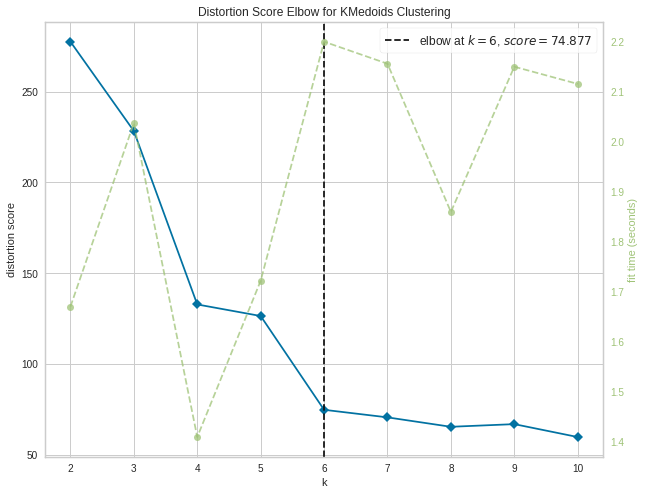

6

In [59]:
kmedoids_model = KMedoids()
elbow = KElbowVisualizer(kmedoids_model, k=(2,11))
elbow.fit(rfm_scaled)
elbow.show()
elbow.elbow_value_

In [60]:
nilai_k = []
sil_score=[]
for kluster in range (2,11):
  kmedoid = KMedoids(n_clusters=kluster)
  nilai_k.append(kluster)
  kmedoid.fit(rfm_scaled)
  from sklearn.metrics import silhouette_score
  score = silhouette_score(rfm_scaled, kmedoid.labels_)
  sil_score.append(score)

In [61]:
tbl_sil_medoid = pd.DataFrame({'Nilai K': nilai_k, 'Silhouette Score' : sil_score})
tbl_sil_medoid

,Nilai K,Silhouette Score
0,2,0.566102
1,3,0.365519
2,4,0.454309
3,5,0.337933
4,6,0.462229
5,7,0.384704
6,8,0.367270
7,9,0.357149
8,10,0.354249


In [62]:
kmedoid_k6 = KMedoids(n_clusters=6)
kmedoid_k6.fit(rfm_scaled)

KMedoids(n_clusters=6)

In [63]:
rfm_kmedoid = rfm.copy()
rfm_kmedoid['Cluster'] = kmedoid_k6.labels_
rfm_kmedoid

,Customer ID,Amount,Frequency,Recency,Cluster
0,12347.0,5633.32,8,1,5
1,12348.0,2019.40,5,74,3
2,12349.0,4428.69,4,18,5
3,12350.0,334.40,1,309,4
4,12351.0,300.93,1,374,4
...,...,...,...,...,...
5769,18283.0,2736.65,22,3,0
5770,18284.0,461.68,1,431,4
5771,18285.0,427.00,1,660,2
5772,18286.0,1296.43,2,476,4


# **Analisis K-Medoid**

In [74]:
rfm_kmedoid['Amount'].describe()

count     5774.000000
mean      1930.006139
std       2889.092437
min          2.950000
25%        342.370000
50%        860.515000
75%       2155.615000
max      23419.290000
Name: Amount, dtype: float64

In [75]:
rfm_kmedoid['Frequency'].describe()

count    5774.000000
mean        5.202632
std         6.105955
min         1.000000
25%         1.000000
50%         3.000000
75%         6.000000
max        43.000000
Name: Frequency, dtype: float64

In [76]:
rfm_kmedoid['Recency'].describe()

count    5774.000000
mean      203.166436
std       209.571199
min         0.000000
25%        27.000000
50%       100.000000
75%       380.750000
max       738.000000
Name: Recency, dtype: float64

In [65]:
rfm_kmedoid[rfm_kmedoid['Cluster']==0].describe()

,Amount,Frequency,Recency,Cluster
count,375.000000,375.000000,375.000000,375.0
mean,10297.406088,22.720000,31.154667,0.0
std,4342.617416,7.962747,55.886655,0.0
min,1820.440000,3.000000,0.000000,0.0
25%,6945.180000,17.000000,4.000000,0.0
50%,9435.130000,21.000000,14.000000,0.0
75%,12810.585500,28.000000,31.000000,0.0
max,23419.290000,43.000000,437.000000,0.0


In [68]:
rfm_kmedoid[rfm_kmedoid['Cluster']==1].describe()

,Amount,Frequency,Recency,Cluster
count,898.000000,898.000000,898.000000,898.0
mean,1015.837385,3.164811,208.397550,1.0
std,1104.674354,2.300116,51.389815,0.0
min,3.750000,1.000000,121.000000,1.0
25%,315.157500,1.000000,164.250000,1.0
50%,672.635000,3.000000,206.500000,1.0
75%,1311.630000,4.000000,253.000000,1.0
max,9864.260000,17.000000,319.000000,1.0


In [69]:
rfm_kmedoid[rfm_kmedoid['Cluster']==2].describe()

,Amount,Frequency,Recency,Cluster
count,648.000000,648.000000,648.000000,648.0
mean,525.039262,1.490741,618.949074,2.0
std,1176.199875,1.086623,65.412203,0.0
min,2.950000,1.000000,509.000000,2.0
25%,146.102500,1.000000,562.750000,2.0
50%,253.940000,1.000000,616.500000,2.0
75%,431.012500,2.000000,668.000000,2.0
max,13916.340000,8.000000,738.000000,2.0


In [70]:
rfm_kmedoid[rfm_kmedoid['Cluster']==3].describe()

,Amount,Frequency,Recency,Cluster
count,1781.000000,1781.000000,1781.000000,1781.0
mean,941.467183,3.075800,41.906794,3.0
std,725.896376,1.713916,30.773936,0.0
min,6.200000,1.000000,0.000000,3.0
25%,388.790000,2.000000,17.000000,3.0
50%,778.500000,3.000000,35.000000,3.0
75%,1286.270000,4.000000,64.000000,3.0
max,5217.440000,8.000000,120.000000,3.0


In [71]:
rfm_kmedoid[rfm_kmedoid['Cluster']==4].describe()

,Amount,Frequency,Recency,Cluster
count,1136.000000,1136.000000,1136.000000,1136.0
mean,783.418073,2.447183,406.236796,4.0
std,931.659938,2.110354,49.845040,0.0
min,3.750000,1.000000,300.000000,4.0
25%,246.500000,1.000000,375.000000,4.0
50%,490.230000,2.000000,404.000000,4.0
75%,980.975000,3.000000,436.000000,4.0
max,11880.840000,20.000000,521.000000,4.0


In [72]:
rfm_kmedoid[rfm_kmedoid['Cluster']==5].describe()

,Amount,Frequency,Recency,Cluster
count,936.000000,936.000000,936.000000,936.0
mean,3699.962355,10.100427,39.592949,5.0
std,1721.171804,3.078745,38.589017,0.0
min,167.420000,3.000000,0.000000,5.0
25%,2457.830000,8.000000,10.000000,5.0
50%,3341.155000,10.000000,27.000000,5.0
75%,4594.442500,12.000000,58.250000,5.0
max,12601.830000,20.000000,217.000000,5.0


Hasil Analisis K-Medoid:

Rata-Rata setiap atribut:
Amount: 1930
Frequency: 5,2
Recency: 203

Cluster 0: Nilai rata-rata amount= 10297,4 ; Frequency: 22,72 ; Recency= 31,15
=> Nilai amount tinggi, frequency sangat tinggi, Recency rendah

Cluster 1: Nilai rata-rata amount= 1015; Freq= 3,16, Recency: 208
=> Nilai amount rendah, frequency rendah, dan recency tinggi

Cluster 2: Nilai rata-rata amount=512 ; freq= 1,4; R= 618
=> nilai amount sangat rendah, frequency sangat rendah, recency sangat tinggi

Cluster 3: A= 941, F= 3,07 R=41,9
=> Nilai amount rendah, frequency rendah, recency sangat rendah

Cluster 4: A= 783, F= 2,47, R= 406
=> amount rendah, frequency rendah, recency sangat tinggi

Cluster 5: A= 3669 F= 10,1 M: 39,59
+> amount sangat tinggi, Frequency sangat rendah, recency sangat rendah

In [64]:
rfm_kmedoid.to_excel("Hasil Clustering-Kmedoid.xls")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  """Entry point for launching an IPython kernel.
